Na uzorku podataka (koji se ispostavlja da neće biti normalne raspodele), testiraćemo Box-Cox i Yeo-Johnson transformacije, kao i druge vrste stepenih transformacija i posmatraćemo se njihovu zavisnost.

Transformacije koje ćemo implementirati:

    1) Logaritamska
    2) Reciprocna
    3) Korene
    4) Box-Cox 
    5) Yeo-Johnson


**Uzorak koji koristimo:** pregledi na web sajtu po minutu, u vremenskom periodu od 3 meseca

In [2]:
# potrebne biblioteke
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Uvozimo podatke, uzorak sa kojim radimo

In [3]:
import os

# formiramo putanju do fajla
current_dir = os.getcwd()

file_name = 'timeseries_views_per_min.csv'
file_path = os.path.join(current_dir, file_name)

try:
    data = pd.read_csv(file_path, index_col = 0)
    print("File loaded successfully")
except FileNotFoundError as e:
    print(f"Error: {e}")

# prikazujemo podatke
df = data.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

File loaded successfully


,datetime,f1
0,1990-03-01 00:00:00,4356.0
1,1990-03-01 00:01:00,1108.0
2,1990-03-01 00:02:00,3753.0
3,1990-03-01 00:03:00,27144.0
4,1990-03-01 00:04:00,1408.0


In [5]:
# isptujemo koliko nula i negativnih vrednosti imamo u skupu podataka sa kojim radimo
# ovo nam je važno jer određene transformacije rade samo sa nenegativnim vrednostima
len(df[df['f1'] == 0]), len(df[df['f1'] < 0])

(5806, 0)

----------------------------------------------------------------------------------------------------------------

Zelimo da proverimo koliko podaci sa kojima radimo odstupaju od normalne raspodele te sprovodimo [test normalnosti.](./README.md#test-normalnosti)

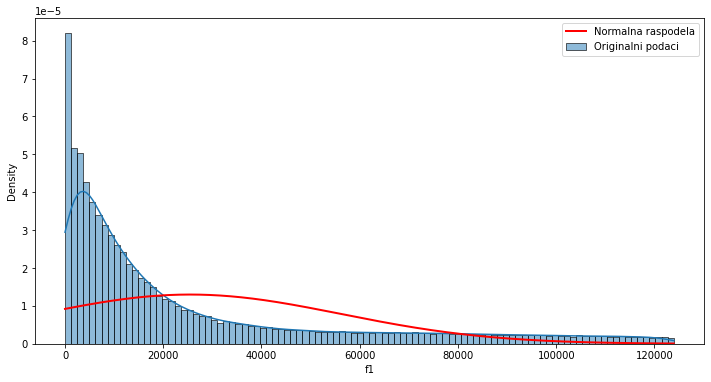

In [17]:
from scipy.stats import norm

data = df['f1']

# pravimo grafik normalne raspodele
# racunamo medijanu i standardnu devijaciju za nase podatke
mean = np.mean(data)
std = np.std(data)

x = np.linspace(min(data), max(data), 5000)
normal_pdf = norm.pdf(x, mean, std)

plt.figure(figsize=(12, 6))

# pravimo histogram originalnih podataka
sns.histplot(data, kde=True, stat='density', label='Originalni podaci', bins=100)

# Plot normal distribution
plt.plot(x, normal_pdf, 'r-', label='Normalna raspodela', linewidth=2)

plt.legend()
plt.show()

Kao sto ocigledno mozemo videti, uzorak **ne prati normalnu raspodelu** i ima vise vrednosti u rasponu od 0 do 30.000, tj ima pozitivnu (desnu asimetriju).

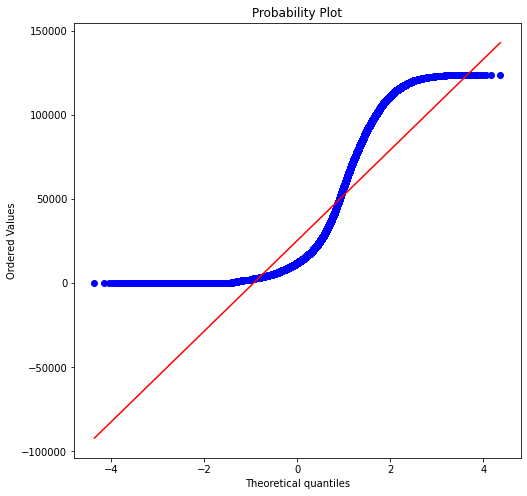

In [66]:
from scipy import stats

plt.figure(figsize = (8,8))
# Q-Q plot
stats.probplot(df['f1'], dist="norm", plot=plt)
plt.show()

Na QQ grafiku, jasno možemo videti da se većina plavih tačaka NE poklapa sa crvenom linijom (pod uglom od 45 stepeni), i stoga, jos jednom, zakljucujemo da naši podaci **ne prate** normalnu raspodelu

Mozemo i izračunati i asimetriju raspodele

In [18]:
import scipy
from scipy.stats import skew

skew_val = skew(df['f1'], axis=0, bias=True)
print(skew_val)

1.538480887364415


Kako je vrednost veća od 0 još jednom potvrđujemo da naši podaci nemaju normalnu raspodelu, već su desno asimetrični, više podataka koncentrisano je na levoj strani, dok su veće vrednosti ređe.

----------------------------------------------------------------------------------------------------------------

Kako bismo imali način za upoređivanje transformacija, definišemo sledeću funkciju koja računa srednju vrednost i medijanu transformisanih podataka

In [67]:
def mean_median_diff(df,col):
    
    data_mean = np.mean(df[col])
    data_median = np.median(df[col])
    
    return round(data_mean,2),round(data_median,2),round(data_mean - data_median,2)

In [68]:
# računamo vrednosti za originalne podatke
f1_mean,f1_median, f1_diff = mean_median_diff(df,'f1')
f1_mean,f1_median, f1_diff

(25463.37, 12121.0, 13342.37)

### Logaritamska transformacija


Logaritamska transformacija ne radi sa negativnim i nula vrednostima, pa ih moramo eliminisati ukoliko postoje u našem skupu podataka.

In [69]:
df_log = df.copy()

In [70]:
# nas skup nema negativne, ali ima nula vrednosti 
# dodajemo 1 na sve vrednosti iz našeg skupa podataka

df_log['f1'] = df_log['f1'].apply(lambda x: x+1)
len(df_log[df_log['f1'] == 0]), len(df_log[df_log['f1'] < 0])

(0, 0)

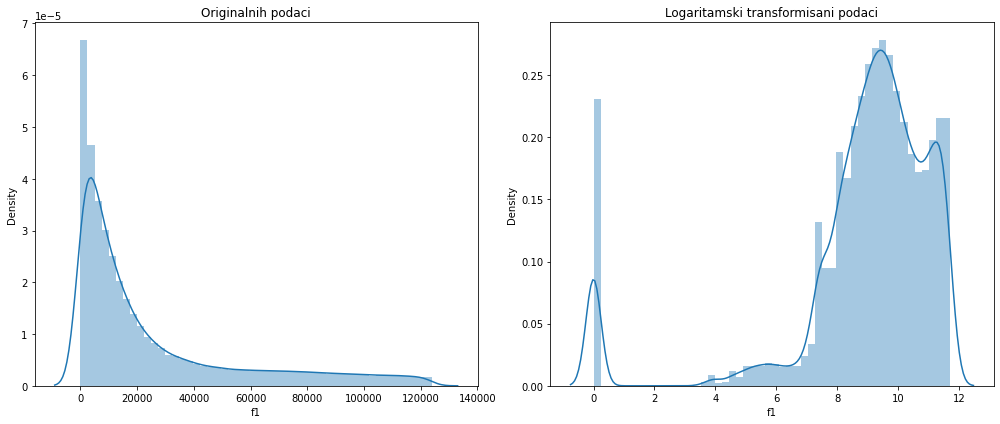

In [71]:
# Log transformacija
df_log['f1'] = np.log(df_log['f1'])

# prikazujemo promenu grafički
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prvi histogram: Originalni podaci
sns.distplot(df['f1'], ax=ax1, kde=True)
ax1.set_title('Originalnih podaci')

## Drugi histogram: Logaritamski transformisani podaci
sns.distplot(df_log['f1'], ax=ax2, kde=True)
ax2.set_title('Logaritamski transformisani podaci')

plt.tight_layout()
plt.show()

In [72]:
# računamo medijanu i srednju vrednost

f1_log_mean,f1_log_median, f1_log_diff = mean_median_diff(df_log,'f1')
f1_log_mean,f1_log_median, f1_log_diff

(8.92, 9.4, -0.49)

**Zaključak:** Srednja vrednost i medijana originalnih podataka su bile veoma udaljene jedna od druge. Nakon logaritamske transformacije, srednja vrednost i medijana su gotovo jednake, što je karakteristika normalno distribuiranih podataka. 

Međutim, ovo nije veoma poželjna raspodela. Pokušaćemo sa drugim transformacijama, da vidimo da li možemo dobiti bolje rezultate.

### Korene transformacije (kvadratna i kubna)

Kvadratna transformacija radi samo sa nenegativnim vrednostima.

In [73]:
df_sqroot = df.copy()
df_cuberoot = df.copy()

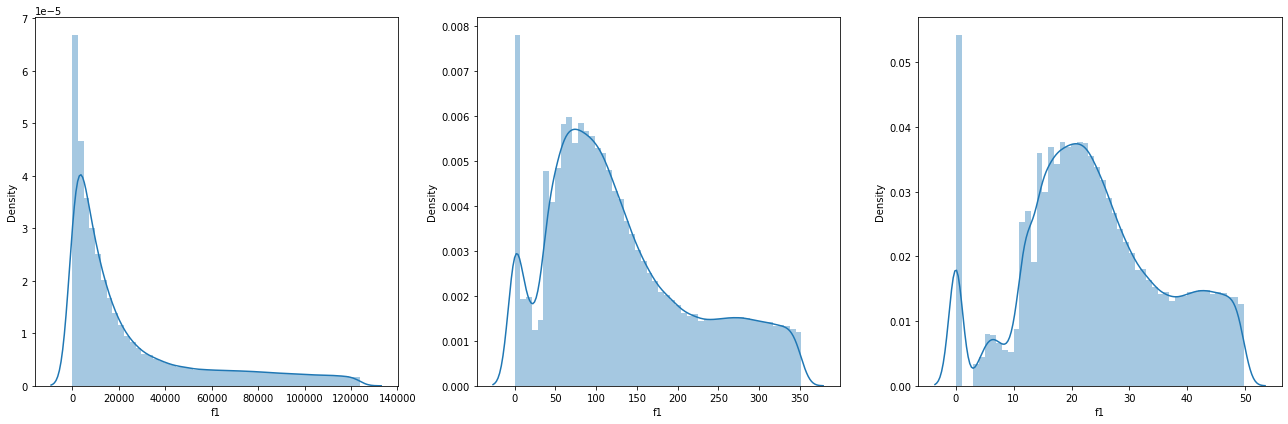

In [76]:
# korena transformacija
df_sqroot['f1'] = np.sqrt(df_sqroot['f1'])

# kubna transformacija
df_cuberoot['f1'] = np.cbrt(df_cuberoot['f1'])

# prikazujemo promene grafički
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


sns.distplot(df['f1'], ax=axes[0], kde=True)
ax1.set_title('Originalnih podaci')


sns.distplot(df_sqroot['f1'], ax=axes[1], kde=True)
ax2.set_title('Transformacija kvadratnog korenovanja')

sns.distplot(df_cuberoot['f1'], ax=axes[2], kde=True)
ax2.set_title('Transformacija kubnog korenovanja')

plt.tight_layout()
plt.show()

In [83]:
# računamo medijanu i srednju vrednost

f1_sqroot_mean,f1_sqroot_median, f1_sqroot_diff = mean_median_diff(df_sqroot,'f1')
print("Square: {}, {}, {}".format(f1_sqroot_mean,f1_sqroot_median, f1_sqroot_diff))

f1_cuberoot_mean,f1_cuberoot_median, f1_cuberoot_diff = mean_median_diff(df_cuberoot,'f1')
print("Square: {}, {}, {}".format(f1_cuberoot_mean,f1_cuberoot_median, f1_cuberoot_diff))

Square: 131.68, 110.1, 21.59
Square: 24.3, 22.97, 1.33


**Zakljucak:** Kvadratnim korenovanjem nismo postogli dobre rezultate, razlika između mediane i srednje vrednosti je i dalje velika. Međutim, primenom kubnog korenovanja, razlika je značajno umanjena, te možemo biti zadovoljni transformacijom. 

### Box-Cox transformacija

In [89]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox


df_boxcox = df.copy()
# uklanjamo nula vrednosti iz skupa podataka
df_boxcox['f1'] = df_boxcox['f1'].apply(lambda x: x + 1)

df_boxcox_vals, fitted_lambda = boxcox(df_boxcox['f1'])

In [90]:
# pravimo novi skup podataka, dodajemo treću kolonu sa transformasanim vrednostima
df_boxcox['f1_boxcox'] = df_boxcox_vals

df_boxcox.head()

,datetime,f1,f1_boxcox
0,1990-03-01 00:00:00,4357.0,31.118471
1,1990-03-01 00:01:00,1109.0,20.485379
2,1990-03-01 00:02:00,3754.0,29.764705
3,1990-03-01 00:03:00,27145.0,52.954603
4,1990-03-01 00:04:00,1409.0,22.078236


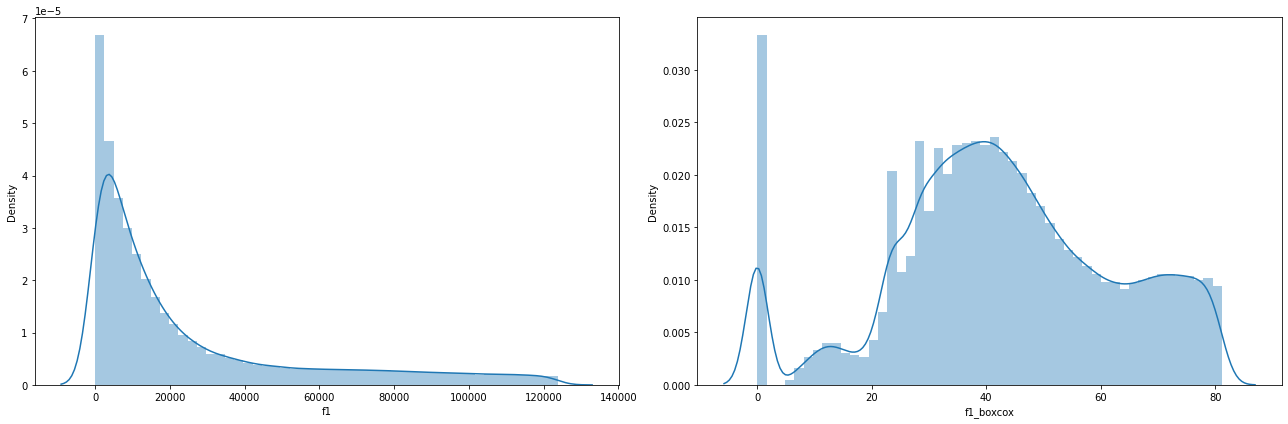

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


sns.distplot(df['f1'], ax=axes[0], kde=True)
ax1.set_title('Originalnih podaci')


sns.distplot(df_boxcox['f1_boxcox'], ax=axes[1], kde=True)
ax2.set_title('Transformacija Box-Cox')

plt.tight_layout()
plt.show()

In [92]:
f1_boxcox_mean,f1_boxcox_median, f1_boxcox_diff = mean_median_diff(df_boxcox,'f1_boxcox')
f1_boxcox_mean,f1_boxcox_median, f1_boxcox_diff

(43.07, 42.02, 1.05)

**Zaključak:** Primenom Box-Cox transformacije, razlika izmedju medijane i srednje vrednosti je dosta mala, te možemo biti zadovoljni transformacijom. 

In [95]:
# primenjujemo inverznu Box-Cox transformaciju

inverse_vals = inv_boxcox(df_boxcox_vals, fitted_lambda)

df_boxcox['f1_inversed'] = inverse_vals
df_boxcox['f1_inversed'] = df_boxcox['f1_inversed'].apply(lambda x : x - 1)

df_boxcox.head()

,datetime,f1,f1_boxcox,f1_inversed
0,1990-03-01 00:00:00,4357.0,31.118471,4356.0
1,1990-03-01 00:01:00,1109.0,20.485379,1108.0
2,1990-03-01 00:02:00,3754.0,29.764705,3753.0
3,1990-03-01 00:03:00,27145.0,52.954603,27144.0
4,1990-03-01 00:04:00,1409.0,22.078236,1408.0


### Yeo-Johnson transformacija

Ova transformacija radi i sa pozitivnim i sa negativnim vrednostima

In [97]:
from scipy.stats import yeojohnson

df_yeoj = df.copy()

df_yeoj_vals, fitted_lambda_yeoj = yeojohnson(df_yeoj['f1'])

In [98]:
df_yeoj['f1_yeoj'] = df_yeoj_vals

df_yeoj.head()

,datetime,f1,f1_yeoj
0,1990-03-01 00:00:00,4356.0,31.118467
1,1990-03-01 00:01:00,1108.0,20.485377
2,1990-03-01 00:02:00,3753.0,29.764701
3,1990-03-01 00:03:00,27144.0,52.954594
4,1990-03-01 00:04:00,1408.0,22.078234


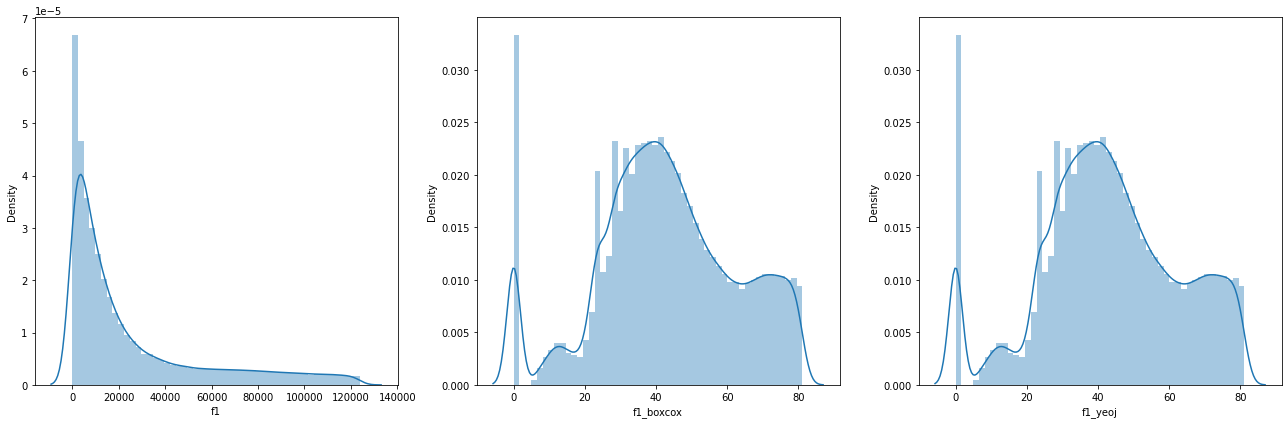

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


sns.distplot(df['f1'], ax=axes[0], kde=True)
ax1.set_title('Originalnih podaci')

sns.distplot(df_boxcox['f1_boxcox'], ax=axes[1], kde=True)
ax2.set_title('Transformacija Box-Cox')

sns.distplot(df_yeoj['f1_yeoj'], ax=axes[2], kde=True)
ax2.set_title('Transformacija Yeo-Johnson')

plt.tight_layout()
plt.show()

In [100]:
f1_yeoj_mean,f1_yeoj_median, f1_yeoj_diff = mean_median_diff(df_yeoj,'f1_yeoj')
f1_yeoj_mean,f1_yeoj_median, f1_yeoj_diff

(43.07, 42.02, 1.05)

**Zaključak:** Primenom Yeo-Johnson transformacije, razlika izmedju medijane i srednje vrednosti je dosta mala, te možemo biti zadovoljni transformacijom. 

In [103]:
# Inverna Yeo-Johnson transformacija
inverse_vals = inv_boxcox(df_yeoj_vals, fitted_lambda_yeoj)

df_yeoj['f1_inversed'] = inverse_vals

# Zbog dodavanja 1 u okviru algoritma transformacije, oduzimamo 1
df_yeoj['f1_inversed'] = df_yeoj['f1_inversed'].apply(lambda x : x - 1)

df_yeoj.head()


,datetime,f1,f1_yeoj,f1_inversed
0,1990-03-01 00:00:00,4356.0,31.118467,4356.0
1,1990-03-01 00:01:00,1108.0,20.485377,1108.0
2,1990-03-01 00:02:00,3753.0,29.764701,3753.0
3,1990-03-01 00:03:00,27144.0,52.954594,27144.0
4,1990-03-01 00:04:00,1408.0,22.078234,1408.0
